# Diabetes Prediction

In [21]:
import numpy as np
import pandas as pd
import pandera.pandas as pa
import altair as alt
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import make_pipeline
from ucimlrepo import fetch_ucirepo 
from sklearn.metrics import (
    accuracy_score, make_scorer, fbeta_score, 
    recall_score, precision_score, ConfusionMatrixDisplay
)
from deepchecks.tabular.checks import FeatureLabelCorrelation, FeatureFeatureCorrelation
from deepchecks.tabular import Dataset

alt.data_transformers.disable_max_rows()
warnings.filterwarnings("ignore", category=FutureWarning, module="deepchecks")

np.random.seed(522)

/Users/alxti/miniforge3/envs/cdc_diabetes_prediction/lib/python3.11/site-packages/deepchecks/core/serialization/dataframe/html.py:16: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Summary

In this project we attempt to build a model to predict diabetes disease. We compared a decision tree model and naive bayes model and found the decision tree is stronger in this context. We used f2-score as our scoring function because detecting diabetes is the priority: a false negative could be much worse then a false positive.

In the test dataset: the decision tree model correctly detected 8283 of 10604 positive cases (recall rate is about 78%). This result does come at a fairly significant cost in terms of false positives (precision rate is about 30%) with 19650 false positives. Depending on the actual cost of false positive this may need significant improvement to be a viable screening model.

## Introduction

In Canada and the USA approximately 10% of people are living with diabetes. In Canada in 2023 approximately 3.7 million people were living with diabetes and in the USA in 2021 approzimately 38.4 million people were living with diabetes. In the USA it is the 8th leading cause of death. Globally an estimated 44% of people living with diabetes are undiagnosed. (Snapshot of Diabetes in Canada, 2023; Rios et al., 2017; Stafford et al., 2025)

In this project we try to predicted diabetes disease based on common health factors. A reliable model could help to prescreen people and recommend following up with a physician for people who are at risk. Given the large number of people living with undiagnosed diabetes this could potentially have a significant positive impact of world health.

The analysis uses the American CDC Behavioural Risk Factor Surveillance System (BRFSS) 2015 Diabetes Health Indicators dataset (UCI ID 891), containing 253,680 survey responses with 21 health-related features and a binary diabetes outcome (0 = no diabetes/pre-diabetes, 1 = diabetes).  
No missing values were present and all features were already encoded numerically. The target classes is imbalanced (≈86% non-diabetic, ≈14% diabetic).

## Methods and Results

The analysis uses the CDC Behavioural Risk Factor Surveillance System (BRFSS) 2015 Diabetes Health Indicators dataset (UCI ID 891), containing 253,680 survey responses with 21 health-related features and a binary diabetes outcome (0 = no diabetes/pre-diabetes, 1 = diabetes). (Dane and Teboul, 2021) 
No missing values were present and all features were already encoded numerically. The target classes are heavily imbalanced (≈86% non-diabetic, ≈14% diabetic).

### EDA
Group-wise mean differences revealed the strongest risk factors for diabetes:
- PhysHlth (days of poor physical health)
- BMI
- Age
- MentHlth (days of poor mental health)
- GenHlth (self-rated general health)

Weakest factors
- HvyAlcoholConsump
- Fruits
- Veggies
- PhysActivity
- Education
- Income

Box plots of the top five predictors clearly separate the diabetic and non-diabetic groups.

### Modeling Approach
The data were split 70/30 into training and test sets with stratification on the target.  
Two classifiers were trained and tuned using 5-fold cross-validated grid search with **f2-score** as the scoring metric. We chose to use f2-score because it is more appropriate than accuracy or f1 because we don't want to miss true positives.

1. **Decision Tree** (class_weight='balanced')  
   Hyperparameters: max_depth ∈ {6,8,10,12,14}, min_samples_leaf ∈ {175, 200, 225, 250}  
   **Best parameters**: max_depth=10, min_samples_leaf=200  
   **Best CV f2-score** = 0.5908

2. **Bernoulli Naive Bayes** (with StandardScaler preprocessing)  
   Hyperparameters: alpha ∈ {1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4}  
   **Best parameters**: alpha=1e-3  
   **Best CV f2-score** = 0.4453

### Results
|         Model | Test Accuracy | Test f2-score | Test recall | Test precision |
|--------------:|--------------:|--------------:|------------:|---------------:|
| Decision Tree |        0.706 |    **0.587** |  **0.783** |         0.293 |
|   Naive Bayes |    **0.814** |        0.460 |      0.489 |     **0.373** |

Table: 1

### Load Data

In [22]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 

# data (as pandas dataframes) 
X = cdc_diabetes_health_indicators.data.features 
y = cdc_diabetes_health_indicators.data.targets 

## Validate Data Before Saving

### X Verification

In [23]:
"""
Checks verified:
Correct data file format
Correct column names
No empty observations (and by extension Missingness not beyond expected threshold)
Correct data types in each column
No outlier or anomalous values

Maximum allowable ranges for the numeric_features were determined from
the schema description in https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators.
"""

# Check that X is a Pandas DataFrame
if not isinstance(X, pd.DataFrame):
    raise TypeError("X object obtained is not a Pandas Dataframe.")

# Create a list of expected column names
column_names = ["HighBP","HighChol","CholCheck","BMI","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity",
                "Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare",
                "NoDocbcCost","GenHlth","MentHlth","PhysHlth","DiffWalk","Sex","Age","Education","Income"]

# Create a list of column names that are binary features
binary_features = ["HighBP","HighChol","CholCheck","Smoker","Stroke","HeartDiseaseorAttack","PhysActivity",
                "Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare",
                "NoDocbcCost","DiffWalk","Sex"]

# Define allowable ranges for numeric features
numeric_features = {"BMI": (5,256),
                    "GenHlth": (1,5),
                    "MentHlth": (0,30),
                    "PhysHlth": (0,30),
                    "Age": (1,13),
                    "Education": (1,6),
                    "Income": (1,8)}

# Check that all expected columns are present
schema_dict = {}
for col_name in binary_features:
    schema_dict[col_name] = pa.Column(int, pa.Check.between(0,1), nullable = False)

# Add numeric features to schema with their respective ranges
for col_name in numeric_features.keys():
    schema_dict[col_name] = pa.Column(int, pa.Check.between(numeric_features[col_name][0],numeric_features[col_name][1]), nullable = False)

schema = pa.DataFrameSchema(schema_dict)

schema.validate(X, lazy = True)

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,40,1,0,0,0,0,1,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,25,1,0,0,1,0,0,...,0,1,3,0,0,0,0,7,6,1
2,1,1,1,28,0,0,0,0,1,0,...,1,1,5,30,30,1,0,9,4,8
3,1,0,1,27,0,0,0,1,1,1,...,1,0,2,0,0,0,0,11,3,6
4,1,1,1,24,0,0,0,1,1,1,...,1,0,2,3,0,0,0,11,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253675,1,1,1,45,0,0,0,0,1,1,...,1,0,3,0,5,0,1,5,6,7
253676,1,1,1,18,0,0,0,0,0,0,...,1,0,4,0,0,1,0,11,2,4
253677,0,0,1,28,0,0,0,1,1,0,...,1,0,1,0,0,0,0,2,5,2
253678,1,0,1,23,0,0,0,0,1,1,...,1,0,3,0,0,0,1,7,5,1


### Y Verification

In [24]:
# Use same template as X verification, only one column
if not isinstance(y, pd.DataFrame):
    raise TypeError("y object obtained is not a Pandas Dataframe.")


schema_dict = {}

target_name = ["Diabetes_binary"]

for col_name in target_name:
    schema_dict[col_name] = pa.Column(int, pa.Check.between(0,1), nullable = False)

schema = pa.DataFrameSchema(schema_dict)

schema.validate(y, lazy = True)

,Diabetes_binary
0,0
1,0
2,0
3,0
4,0
...,...
253675,0
253676,1
253677,0
253678,0


### Save Raw Data

In [25]:
# check if raw folder exists
raw_data_path = "../data/raw"

if not os.path.exists(raw_data_path):
    os.makedirs(raw_data_path)

## Save Raw Data
X.to_csv("../data/raw/diabetes_raw_features.csv")
y.to_csv("../data/raw/diabetes_raw_targets.csv")

### Data Wrangling

In [26]:
# No major cleaning needed — dataset is already very clean!
# Combine features and targets to get a overview of the full data set
df = X.copy()
df['diabetes'] = y

# Quick info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth              253680 non-null  int64
 15  PhysHlth              253680 non-n

In [27]:
df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


In [28]:
df.tail()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
253675,1,1,1,45,0,0,0,0,1,1,...,0,3,0,5,0,1,5,6,7,0
253676,1,1,1,18,0,0,0,0,0,0,...,0,4,0,0,1,0,11,2,4,1
253677,0,0,1,28,0,0,0,1,1,0,...,0,1,0,0,0,0,2,5,2,0
253678,1,0,1,23,0,0,0,0,1,1,...,0,3,0,0,0,1,7,5,1,0
253679,1,1,1,25,0,0,1,1,1,0,...,0,2,0,0,0,0,9,6,2,1


### Data Summary

All the features in this dataset were selected by clinician to be relevent to a person having diabetes. We will use all features in our model. 

In [29]:
df.describe()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,diabetes
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,0.811420,...,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875,0.139333
std,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,0.391175,...,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148,0.346294
min,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000,0.000000
50%,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000,0.000000
max,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000,1.000000


In [30]:
'''
These checks ensure data quality by verifying:
- Checking if duplicate rows exist in the dataset, preventing redundant data points.
  (We are not dropping duplicates automatically to avoid unintentional data loss.)
  (For the purpose of this dataset, because we already finished the analysis, we will accept the duplicate if any exist.)
- Checking for outlier in ("BMI", "MentHlth", "PhysHlth") columns to see if they have extreme outliers based on the IQR rule,
  which helps maintain data integrity and model robustness.
  (For the purpose of this dataset, we will accept the outlier value because it is a valid measurement.)
- Categorical validation is not applicable for this dataset
'''

def iqr_outliers(series: pd.Series) -> bool:
    """Return True if all values are within 1.5 * IQR (no extreme outliers)"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.between(lower_bound, upper_bound).all()


# Define the schema with meaningful checks
diabetes_schema = pa.DataFrameSchema(
    columns={
        "BMI": pa.Column(float, nullable=False),
        "MentHlth": pa.Column(float, nullable=False),
        "PhysHlth": pa.Column(float, nullable=False),
    },
    checks=[
        # 1. No duplicate rows
        pa.Check(
            lambda df: ~df.duplicated().any(),
            error="DUPLICATE_ROWS: Found duplicate observations. Use df.drop_duplicates() to remove them."
        ),
        
        # 2. No extreme outliers in continuous variables using IQR rule
        pa.Check(
            lambda df: iqr_outliers(df["BMI"]),
            error="OUTLIERS_IN_BMI: Extreme outliers detected in BMI (beyond 1.5 × IQR). Consider winsorizing or removing."
        ),
        pa.Check(
            lambda df: iqr_outliers(df["MentHlth"]),
            error="OUTLIERS_IN_MENTHLTH: Extreme values in MentHlth (beyond 1.5 × IQR)."
        ),
        pa.Check(
            lambda df: iqr_outliers(df["PhysHlth"]),
            error="OUTLIERS_IN_PHYSHLTH: Extreme values in PhysHlth (beyond 1.5 × IQR)."
        )
    ]
)

# Validate with lazy=True to see all errors at once
try:
    diabetes_schema.validate(df, lazy=True)
    print("All checks passed! Dataset is clean and ready for modeling.")
except pa.errors.SchemaErrors as e:
    print("Validation failed! See errors below:")
    print(e.failure_cases)  # Shows detailed failure report

Validation failed! See errors below:
     column failure_case index   schema_context  \
3      None        False  None  DataFrameSchema   
4      None        False  None  DataFrameSchema   
5      None        False  None  DataFrameSchema   
6      None        False  None  DataFrameSchema   
0       BMI        int64  None           Column   
1  MentHlth        int64  None           Column   
2  PhysHlth        int64  None           Column   

                                               check  check_number  
3  DUPLICATE_ROWS: Found duplicate observations. ...           0.0  
4  OUTLIERS_IN_BMI: Extreme outliers detected in ...           1.0  
5  OUTLIERS_IN_MENTHLTH: Extreme values in MentHl...           2.0  
6  OUTLIERS_IN_PHYSHLTH: Extreme values in PhysHl...           3.0  
0                                   dtype('float64')           NaN  
1                                   dtype('float64')           NaN  
2                                   dtype('float64')           NaN  


### Visualizations

In [31]:
diabetes_count = pd.DataFrame(df['diabetes'].value_counts()).reset_index()

alt.Chart(diabetes_count).mark_bar().encode(
    x=alt.X('diabetes:O', title='Has Diabetes'),
    y="count",
    color="diabetes:N"
).properties(title='Count of Diabetes vs Non-Diabetes Recores in Dataset')

alt.Chart(...)

Figure 1

In [32]:
df_sample = df.sample(n=1000, random_state=522)
features = df_sample.columns.to_list()
df_sample_long = pd.melt(df_sample, id_vars=["diabetes"], value_vars=features[:-1], var_name="feature", value_name="feature_value") 

histograms = alt.Chart(df_sample_long).mark_bar().encode(
    x=alt.X("feature_value:O"), # Chose to use ordinal instead of quantitative because this works better for most features
    y=alt.Y("count()", title="Count").stack(False),
    color=alt.Color("diabetes:N"),
).properties(
    width=150,
    height=150,
).facet(
    "feature:N",
    columns=3,
).resolve_scale(
    x="independent",
    y="independent",   
).properties(
    title='Histograms of Features',
)

histograms

alt.FacetChart(...)

Figure 2

In [33]:
# For binary features boxplot is not infomative
non_binary_features = ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
df_sample_nonbinary = df_sample_long[df_sample_long["feature"].isin(non_binary_features)]

alt.Chart(df_sample_nonbinary).mark_boxplot().encode(
    x='diabetes:N',
    y='feature_value:Q',
    color='diabetes:N'
).facet(
    column='feature:N'
).properties(
    title='Boxplots for Non-Binary Features',
).resolve_scale(
    y="independent"
)


alt.FacetChart(...)

Figure 3

In [34]:
# split the data 70-30 split
train_df, test_df = train_test_split(
    df, test_size=0.3, random_state=522, stratify=df['diabetes']
)

# check if processed folder exists
processed_data_path = "../data/processed"

if not os.path.exists(processed_data_path):
    os.makedirs(processed_data_path)

# Save processed data
train_df.to_csv(processed_data_path+"/diabetes_train.csv", index=False)
test_df.to_csv(processed_data_path+"/diabetes_test.csv", index=False)

In [35]:
X_train = train_df.drop('diabetes', axis=1)
y_train = train_df['diabetes']
X_test  = test_df.drop('diabetes', axis=1)
y_test  = test_df['diabetes']

In [36]:
# Create correlation chart
correlation_matrix = X_train.corr()
correlation_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_long.columns = ['Feature 1', 'Feature 2', 'Correlation']

alt.Chart(correlation_long).mark_rect().encode(
    x='Feature 1:O',
    y='Feature 2:O',
    color=alt.Color('Correlation:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Feature 1', 'Feature 2', 'Correlation']
).properties(
    width=600,
    height=600,
    title="Correlation Heatmap"
)

alt.Chart(...)

In [37]:
'''
- Target/response variable follows expected distribution
  (In the diabetes dataset, we expect the prevalence of diabetes to be around 13-15%.)
  
Validate training data for anomalous correlations:
- Feature-label correlations (target vs features)
- Feature-feature correlations (between features)

Thresholds set based on domain knowledge.

We perform these checks on training data only because including test data here could lead to data leakage 
and invalidate the evaluation of model generalization.
'''

# Target variable follows expected distribution
# In this dataset: ~13–15% diabetes is normal, >30% or <5% is suspicious

distribution_schema = pa.DataFrameSchema(
    checks=[pa.Check(
        lambda df: df.mean().between(0.05, 0.30),
        error="ANOMALOUS_TARGET_DISTRIBUTION: Diabetes prevalence should be 5–30% (actual: {:.1%})"
        )
    ]
)

distribution_schema.validate(train_df[['diabetes']], lazy=True)

# Combine features and target into a dataset for validation
diabetes_train_ds = Dataset(
    df=train_df,   
    label="diabetes",                          
    cat_features=[]
)

# Check that feature-label predictive power score (PPS) is below 0.9
check_feat_lab_corr = FeatureLabelCorrelation().add_condition_feature_pps_less_than(0.9)
check_feat_lab_corr_result = check_feat_lab_corr.run(diabetes_train_ds)

# Check that no feature pairs have correlation above 0.92
check_feat_feat_corr = FeatureFeatureCorrelation().add_condition_max_number_of_pairs_above_threshold(
    threshold=0.92, n_pairs=0   
)
check_feat_feat_corr_result = check_feat_feat_corr.run(diabetes_train_ds)

# Raise errors if any checks fail
if not check_feat_lab_corr_result.passed_conditions():
    raise ValueError("Feature-Label correlation exceeds the maximum acceptable threshold.")

if not check_feat_feat_corr_result.passed_conditions():
    raise ValueError("Feature-feature correlation exceeds the maximum acceptable threshold.")

### Classification Analysis

In [38]:
f2_scorer = make_scorer(fbeta_score, beta=2)

In [39]:
tree = DecisionTreeClassifier(random_state=522, class_weight='balanced')

tree_params = {
    'max_depth': [6, 8, 10, 12, 14],
    'min_samples_leaf': [175, 200, 225, 250]
}

tree_grid = GridSearchCV(tree, tree_params, cv=5, scoring=f2_scorer, n_jobs=1)
tree_grid.fit(X_train, y_train)

best_tree = tree_grid.best_estimator_
print("Best Decision Tree params:", tree_grid.best_params_)
print("Best CV f2-score:", tree_grid.best_score_.round(4))

Best Decision Tree params: {'max_depth': 10, 'min_samples_leaf': 225}
Best CV f2-score: 0.5919


In [40]:
preprocessor = make_column_transformer(
    (StandardScaler(), X_train.columns)
)

nb_pipe = make_pipeline(
    preprocessor,
    BernoulliNB()
)

nb_params = {'bernoullinb__alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]}

knn_grid = GridSearchCV(nb_pipe, nb_params, cv=5, scoring=f2_scorer, n_jobs=1)
knn_grid.fit(X_train, y_train)

best_nb = knn_grid.best_estimator_
print("Best NB k:", knn_grid.best_params_)
print("Best CV f2-score:", knn_grid.best_score_.round(4))

Best NB k: {'bernoullinb__alpha': 0.001}
Best CV f2-score: 0.4604


In [41]:
models = {
    'Decision Tree': best_tree,
    'Naive Bayes': best_nb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Test Accuracy': round(accuracy_score(y_test, y_pred),3),
        'Test f2-score': round(fbeta_score(y_test, y_pred, beta=2),3),
        'Test recall': round(recall_score(y_test, y_pred),3),
        'Test precision': round(precision_score(y_test, y_pred),3),
    })

score_df = pd.DataFrame(results)
score_df

,Model,Test Accuracy,Test f2-score,Test recall,Test precision
0,Decision Tree,0.706,0.587,0.784,0.293
1,Naive Bayes,0.814,0.460,0.489,0.373


### Result Visualizations

In [42]:
score_melt = score_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

alt.Chart(score_melt).mark_bar().encode(
    x='Model:N',
    y='Score:Q',
    color='Model:N',
    column='Metric:N'
).properties(
    title='Decision Tree vs Naive Bayes Performance on Test Set'
)

alt.Chart(...)

Figure 4

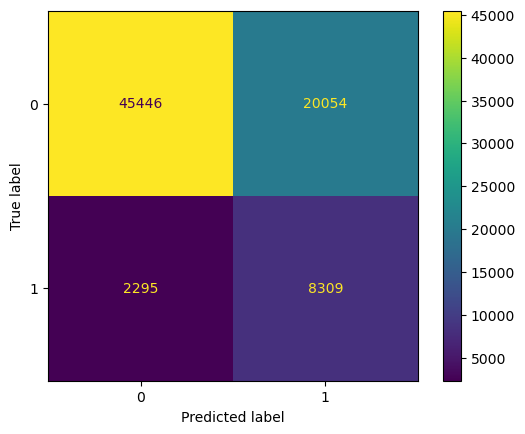

In [43]:
# Confusion matrix for best model (decision tree)

ConfusionMatrixDisplay.from_estimator(
    best_tree,
    X_test,
    y_test,
    values_format="d",
)

Figure 5

## Discussion

The current performance of the tree model is likely already good enough to offer some benefit in the real world given the large number of people with undiagnosed diabetes. However the the recall score likely could be impoved on and the precision score definitely leaves something to be desired. 

We were surprised by the high rate of false positives. This might be an indication of how many non-diabetic people are at risk.

Further improvements to predicting diabetes could likely be found by 1) trying a wider veriety of model type and using a wider hyperperameter search 2) possibly through more feature engineering. 

A future study could be done to find a smaller set of the most easy to obtain features. Such a model would be more usable by the average person. Some work is needed to determine this smaller number of easy to obtain features that doesn't significantly reduce model performance.

Another question is if a regression model could be made that predicts a persons risk as a percent chance of developing diabetes. Longitudinal data might be required for this type of prediction.

## References

Dane, Sohier, and Alex Teboul. Diabetes Health Indicators Dataset. 2021, https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset/data.

Kelly, Markelle, et al. The UCI Machine Learning Repository. 2021, Utilized the ucimlrepo library for data access. Further documentation on the libraryis located at https://github.com/uci-ml-repo/ucimlrepo.archive.ics.uci.edu/ml.

Python 3.12.12 documentation. 2021-2025, https://docs.python.org/3.12/reference/index.html.

Rios, Nilka Burrows, et al. Incidence of End-Stage Renal Disease Attributed to Diabetes Among Persons with Diagnosed Diabetes — United States and Puerto Rico. Morb Mortal Wkly Rep, 66(43), Nov. 2017, http://dx.doi.org/10.15585/mmwr.mm6643a2, pp. 1165–70.

Snapshot of Diabetes in Canada, 2023. 2023, https://www.canada.ca/en/public-health/services/publications/diseases-conditions/snapshot-diabetes-canada-2023.html.

Stafford, Lauryn K, et al. “Global, regional, and national cascades of diabetes care, 2000–23: a systematic review and modelling analysis using findings from the Global Burden of Disease Study”. The Lancet Diabetes & Endocrinology, 13(11), 2025, https://doi.org/10.1016/S2213-8587(25)00217-7, pp. 924–34.
